In [79]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [278]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        self.train_loss_history = []
        self.test_loss_history = []
        
    def init_layers(self):
        #np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #delta = y - y_predict
        #loss = np.dot(delta, delta.T)
        #return np.squeeze(loss)
        return np.power(y_predict - y, 2).mean()
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*(y_predict-y)
        #dA_prev = delta * np.ones(y.shape).reshape(1,-1)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size=16):
        for i in range(epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(0 ,x_train.shape[0], batch_size):
                start = j
                end = j+batch_size
                if end >= x_train.shape[0]:
                    end = x_train.shape[0]-1
                x_min = x_train[start:end]
                y_min = y_train[start:end]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            y_train_predict = self.predict(x_train.T)
            y_test_predict = self.predict(x_test.T)
            train_loss = self.get_loss_value(np.array([y_train]), y_train_predict)
            test_loss = self.get_loss_value(np.array([y_test]), y_test_predict)
            self.train_loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)
            if (i+1) % 100 == 0:
                print("Eposh : %4d/%d || training loss : %lf || testing loss : %lf" % (i+1, epochs, train_loss, test_loss))
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return np.squeeze(y_predict)
    
    def get_loss_history(self):
        return self.train_loss_history, self.test_loss_history

In [279]:
# https://quantdare.com/create-your-own-deep-learning-framework-using-numpy/
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001

In [280]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [281]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [282]:
# split data
#data = Normalizer(norm='l1').fit_transform(data)
x_train, x_test, y_train, y_test = train_test_split(data.to_numpy(), heating.to_numpy(), test_size=0.25, random_state=42)

In [283]:
model = myNN(nn_architecture, learning_rate)

In [284]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 32.254953 || testing loss : 35.424833
Eposh :  200/2000 || training loss : 31.553761 || testing loss : 34.514937
Eposh :  300/2000 || training loss : 31.473581 || testing loss : 34.062282
Eposh :  400/2000 || training loss : 30.634028 || testing loss : 33.208611
Eposh :  500/2000 || training loss : 29.732230 || testing loss : 33.010491
Eposh :  600/2000 || training loss : 28.111894 || testing loss : 31.015485
Eposh :  700/2000 || training loss : 26.660968 || testing loss : 29.423850
Eposh :  800/2000 || training loss : 24.831642 || testing loss : 27.253002
Eposh :  900/2000 || training loss : 22.637772 || testing loss : 24.967171
Eposh : 1000/2000 || training loss : 20.237175 || testing loss : 22.355399
Eposh : 1100/2000 || training loss : 18.145621 || testing loss : 19.968946
Eposh : 1200/2000 || training loss : 16.372265 || testing loss : 17.926230
Eposh : 1300/2000 || training loss : 14.958595 || testing loss : 16.388574
Eposh : 1400/2000 || trai

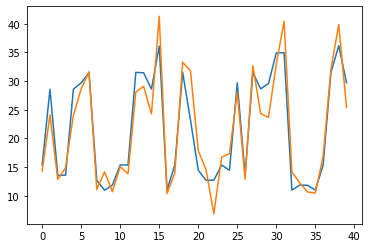

In [285]:
y_predict = model.predict(X_train.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_train[:40])
plt.show()

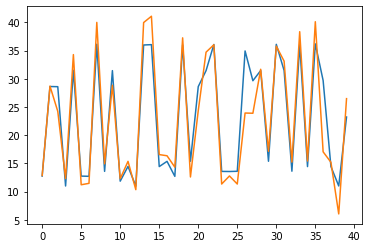

In [286]:
y_predict = model.predict(X_test.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_test[:40])
plt.show()

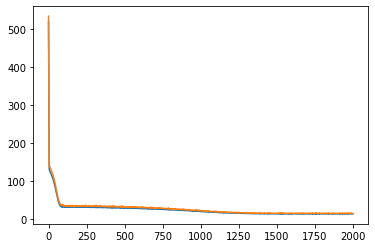

In [287]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
plt.plot(t, train_loss)
plt.plot(t, test_loss)
plt.show()

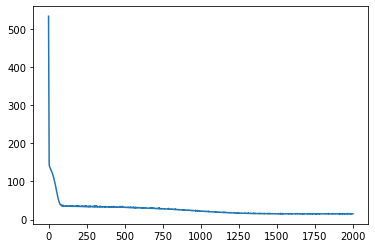

In [288]:
plt.plot(t, test_loss)
plt.show()